In [1]:
#See: https://github.com/Tathagatd96/Deep-Autoencoder-using-Tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
from tensorflow.contrib.layers import fully_connected

/Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/mattmann/git/buildout.python/python-3.7/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/mat

In [3]:
mnist=input_data.read_data_sets("./MNIST_data/",one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./MNIST_data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting ./MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [4]:
tf.reset_default_graph()

In [5]:
num_inputs=784    #28x28 pixels
num_hid1=392
num_hid2=196
num_hid3=num_hid1
num_output=num_inputs
lr=0.01
actf=tf.nn.relu

In [6]:
X=tf.placeholder(tf.float32,shape=[None,num_inputs])
initializer=tf.variance_scaling_initializer()

w1=tf.Variable(initializer([num_inputs,num_hid1]),dtype=tf.float32)
w2=tf.Variable(initializer([num_hid1,num_hid2]),dtype=tf.float32)
w3=tf.Variable(initializer([num_hid2,num_hid3]),dtype=tf.float32)
w4=tf.Variable(initializer([num_hid3,num_output]),dtype=tf.float32)

b1=tf.Variable(tf.zeros(num_hid1))
b2=tf.Variable(tf.zeros(num_hid2))
b3=tf.Variable(tf.zeros(num_hid3))
b4=tf.Variable(tf.zeros(num_output))

hid_layer1=actf(tf.matmul(X,w1)+b1)
hid_layer2=actf(tf.matmul(hid_layer1,w2)+b2)
hid_layer3=actf(tf.matmul(hid_layer2,w3)+b3)
output_layer=actf(tf.matmul(hid_layer3,w4)+b4)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
loss=tf.reduce_mean(tf.square(output_layer-X))
optimizer=tf.train.AdamOptimizer(lr)
train=optimizer.minimize(loss)
init=tf.global_variables_initializer()

epoch 0 loss 0.029061365872621536
epoch 1 loss 0.02432180754840374
epoch 2 loss 0.025356177240610123
epoch 3 loss 0.023578278720378876
epoch 4 loss 0.021880745887756348


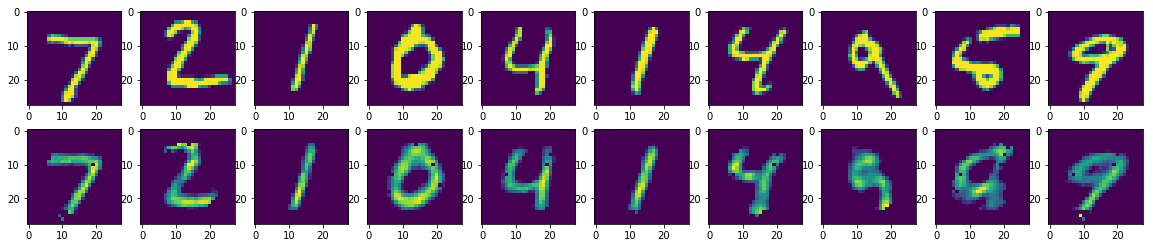

In [8]:
num_epoch=5
batch_size=150
num_test_images=10

with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epoch):
        
        num_batches=mnist.train.num_examples//batch_size
        for iteration in range(num_batches):
            X_batch,y_batch=mnist.train.next_batch(batch_size)
            sess.run(train,feed_dict={X:X_batch})
            
        train_loss=loss.eval(feed_dict={X:X_batch})
        print("epoch {} loss {}".format(epoch,train_loss))
        

    results=output_layer.eval(feed_dict={X:mnist.test.images[:num_test_images]})
    
    #Comparing original images with reconstructions
    f,a=plt.subplots(2,10,figsize=(20,4))
    for i in range(num_test_images):
        a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
        a[1][i].imshow(np.reshape(results[i],(28,28)))

In [9]:
class StackedAutoencoder:
    def __init__(self, input_dim, num_hidden_layers=3, epoch=100, batch_size=250, learning_rate=0.01):
        self.epoch = epoch
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.idim = [None]*num_hidden_layers
        self.hdim = [None]*num_hidden_layers
        self.hidden = [None]*num_hidden_layers
        self.weights = [None]*num_hidden_layers
        self.biases = [None]*num_hidden_layers

        x = tf.placeholder(dtype=tf.float32, shape=[None, input_dim])
        initializer=tf.variance_scaling_initializer()
        #initializer=tf.random.normal
        output_dim = input_dim
        act=tf.nn.relu
        
        # network construction - [input to hidden]            
        for i in range(0, num_hidden_layers):
            self.idim[i] = int(input_dim / (2*i)) if i else input_dim 
            self.hdim[i] = int(input_dim / (2*(i+1))) if i < num_hidden_layers-1 else int(input_dim/2)
            print('%s, weights [%d, %d] biases %d' % ("hidden layer "+str(i+1) if i else "input to hidden layer 1", self.idim[i], self.hdim[i], self.hdim[i]))
            self.weights[i] = tf.Variable(initializer([self.idim[i], self.hdim[i]]), dtype=tf.float32, name='weights'+str(i))
            self.biases[i] = tf.Variable(tf.zeros([self.hdim[i]]), name='biases'+str(i))
            
            if i == 0:
                self.hidden[i] = act(tf.matmul(x, self.weights[i]) + self.biases[i])
            else:
                self.hidden[i] = act(tf.matmul(self.hidden[i-1], self.weights[i]) + self.biases[i])
        
        #output layer
        print('output layer, weights [%d, %d] biases %d' % (self.hdim[num_hidden_layers-1], output_dim, output_dim))
        self.output_weight = tf.Variable(initializer([self.hdim[num_hidden_layers-1], output_dim]), dtype=tf.float32, name='output_weight')
        self.output_bias = tf.Variable(tf.zeros([output_dim]), name='output_bias')
        self.output_layer = act(tf.matmul(self.hidden[num_hidden_layers-1], self.output_weight)+self.output_bias)


        self.x = x
        self.loss = tf.reduce_mean(tf.square(self.output_layer-self.x))
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss)
        #self.loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(self.x, self.output_layer))))
        #self.train_op = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)
        
        self.saver = tf.train.Saver()

    def train_dataset(self, dataset):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(self.epoch):
                batch_num=0
                num_batches=mnist.train.num_examples//batch_size
                for iteration in range(num_batches):
                    X_batch, y_batch = mnist.train.next_batch(batch_size)
                    l, _ = sess.run([self.loss, self.train_op], feed_dict={self.x: X_batch})
                    batch_num += 1
                
                print('epoch {0}: loss = {1}'.format(i, l))
                self.saver.save(sess, './model.ckpt')        
        
    def train(self, data):
        features = data
        features_placeholder = tf.placeholder(features.dtype, features.shape)
        dataset = tf.data.Dataset.from_tensor_slices((features_placeholder))
        dataset = dataset.shuffle(buffer_size=100)
        dataset = dataset.batch(self.batch_size)

        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(self.epoch):
                batch_num=0
                iter = dataset.make_initializable_iterator()
                sess.run(iter.initializer, feed_dict={features_placeholder: features})
                iter_op = iter.get_next()
                
                while True:
                    try:
                        batch_data = sess.run(iter_op)
                        l, _ = sess.run([self.loss, self.train_op], feed_dict={self.x: batch_data})
                        batch_num += 1
                    except tf.errors.OutOfRangeError:
                        break
                
                print('epoch {0}: loss = {1}'.format(i, l))
                self.saver.save(sess, './model.ckpt')
        
    def test(self, data):
        with tf.Session() as sess:
            self.saver.restore(sess, './model.ckpt')
            hidden, reconstructed = sess.run([self.hidden[num_hidden_layers-1], self.output_layer], feed_dict={self.x: data})
        print('input', data)
        print('compressed', hidden)
        print('reconstructed', reconstructed)
        return reconstructed
    
    def classify(self, data, labels):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.saver.restore(sess, './model.ckpt')
            hidden, reconstructed = sess.run([self.hidden[num_hidden_layers-1], self.output_layer], feed_dict={self.x: data})
            reconstructed = reconstructed[0]
            # loss = sess.run(self.all_loss, feed_dict={self.x: data})
            print('data', np.shape(data))
            print('reconstructed', np.shape(reconstructed))
            loss = np.sqrt(np.mean(np.square(data - reconstructed), axis=1))
            print('loss', np.shape(loss))
            horse_indices = np.where(labels == 7)[0]
            not_horse_indices = np.where(labels != 7)[0]
            horse_loss = np.mean(loss[horse_indices])
            not_horse_loss = np.mean(loss[not_horse_indices])
            print('horse', horse_loss)
            print('not horse', not_horse_loss)
            return hidden

    def decode(self, encoding):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.saver.restore(sess, './model.ckpt')
            reconstructed = sess.run(self.output_layer, feed_dict={self.hidden[num_hidden_layers-1]: encoding})
        img = np.reshape(reconstructed, (32, 32))
        return img
    
    def results(self, data):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            self.saver.restore(sess, './model.ckpt')
            results = sess.run(self.output_layer, feed_dict={self.x:data})
        
        return results

In [10]:
s_ae = StackedAutoencoder(784, num_hidden_layers=3, epoch=5, batch_size=150, learning_rate=0.01)
s_ae.train_dataset(mnist.train)

input to hidden layer 1, weights [784, 392] biases 392
hidden layer 2, weights [392, 196] biases 196
hidden layer 3, weights [196, 392] biases 392
output layer, weights [392, 784] biases 784
epoch 0: loss = 0.023740028962492943
epoch 1: loss = 0.02084122598171234
epoch 2: loss = 0.019481707364320755
epoch 3: loss = 0.019959360361099243
epoch 4: loss = 0.017838578671216965


In [11]:
results = s_ae.results(mnist.test.images[:num_test_images])

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./model.ckpt


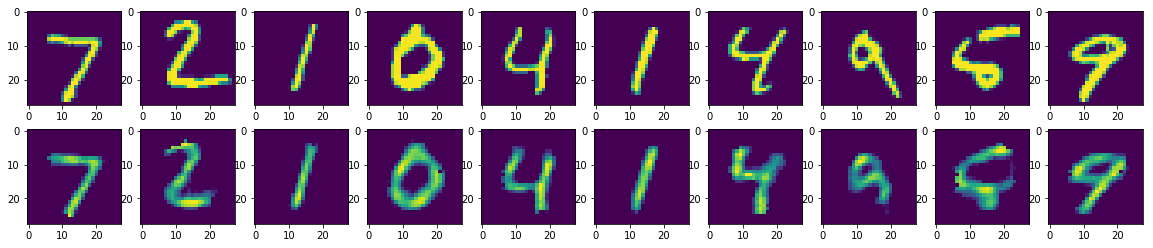

In [12]:
#Comparing original images with reconstructions
f,a=plt.subplots(2,10,figsize=(20,4))
for i in range(num_test_images):
    a[0][i].imshow(np.reshape(mnist.test.images[i],(28,28)))
    a[1][i].imshow(np.reshape(results[i],(28,28)))